<a id='Top'></a>

# Choice of output intervals<a class='tocSkip'></a>

Length and number of output intervals does not influence accuracy.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import sys
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
from lifelines import KaplanMeierFitter

# Make modules in "src" dir visible`
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(os.path.join(project_dir, 'src'))

import dataset
from model import Model
import utils

matplotlib.style.use('multisurv.mplstyle')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>DataLoader</code></a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Evaluate</a></span></li></ul></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Save-to-file" data-toc-modified-id="Save-to-file-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Save to file</a></span></li></ul></li></ul></div>

In [2]:
DATA = utils.INPUT_DATA_DIR
MODELS = utils.TRAINED_MODEL_DIR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# `DataLoader`

In [3]:
dataloaders = utils.get_dataloaders(
    data_location=DATA,
    labels_file='../data/labels.tsv',
    modalities=['clinical', 'mRNA'],
#     wsi_patch_size=299,
#     n_wsi_patches=5,
#     exclude_patients=exclude_cancers,
    return_patient_id=True
)

Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 1092

Batch size: 128


# Model


Try several different discretization schemes of the continuous time scale with two different approaches: equidistant times (several variations) or equidistant survival probabilities (propsed by [Kvamme and Borgan, 2019](https://arxiv.org/abs/1910.06724)).

The survival probability scheme is based on the distribution of the event times. Estimate the survival function using the Kaplan-Meier estimator and make a grid of equidistant estimates (corresponding to quantiles of the input times). The result is a more dense grid in intervals with more events.

In [4]:
labels = [(t, e) for t, e in dataloaders['train'].dataset.label_map.values()]
durations = [t for t, _ in labels]
events = [e for _, e in labels]

survival_prob_interval_cuts = utils.discretize_time_by_duration_quantiles(durations, events, 20)
survival_prob_interval_cuts = torch.from_numpy(survival_prob_interval_cuts)

In [5]:
# Interval - saved weight pairs
int_and_weights = {
    '30 one-year intervals':
    {'intervals': torch.arange(0., 365 * 31, 365),
     'weights': os.path.join(MODELS, 'clinical_mRNA_lr0.005_epoch43_acc0.81.pth')},
    '20 one-year intervals':
    {'intervals': torch.arange(0., 365 * 21, 365),
     'weights': os.path.join(MODELS, 'clinical_mRNA_lr0.005_20_1year_intervals_epoch35_acc0.80.pth')},
    '10 one-year intervals':
    {'intervals': torch.arange(0., 365 * 11, 365),
     'weights': os.path.join(MODELS, 'clinical_mRNA_lr0.005_10_1year_intervals_epoch37_acc0.80.pth')},
    '20 half-year intervals':
    {'intervals': torch.arange(0., 365 * 10.1, 365 / 2),
     'weights': os.path.join(MODELS, 'clinical_mRNA_lr0.005_20_half-year_intervals_epoch47_acc0.80.pth')},
    '5 one-year intervals':
    {'intervals': torch.arange(0., 365 * 6, 365),
     'weights': os.path.join(MODELS, 'clinical_mRNA_lr0.005_5_1year_intervals_epoch39_acc0.80.pth')},
    '10 half-year intervals':
    {'intervals': torch.arange(0., 365 * 5.1, 365 / 2),
     'weights': os.path.join(MODELS, 'clinical_mRNA_lr0.005_10_half-year_intervals_epoch35_acc0.79.pth')},
    '20 variable intervals':
    {'intervals': survival_prob_interval_cuts,
     'weights': os.path.join(MODELS, 'clinical_mRNA_lr0.005_discretized_by_duration_quantiles_epoch50_acc0.79.pth')}
}

In [6]:
models = {}

for x in int_and_weights:
    models[x] = Model(
        dataloaders=dataloaders,
        output_intervals=int_and_weights[x]['intervals'],
        device=device)

    models[x].load_weights(int_and_weights[x]['weights'])
    print()

Instantiating MultiSurv model...
Load model weights:
/mnt/dataA/multisurv_models/clinical_mRNA_lr0.005_epoch43_acc0.81.pth

Instantiating MultiSurv model...
Load model weights:
/mnt/dataA/multisurv_models/clinical_mRNA_lr0.005_20_1year_intervals_epoch35_acc0.80.pth

Instantiating MultiSurv model...
Load model weights:
/mnt/dataA/multisurv_models/clinical_mRNA_lr0.005_10_1year_intervals_epoch37_acc0.80.pth

Instantiating MultiSurv model...
Load model weights:
/mnt/dataA/multisurv_models/clinical_mRNA_lr0.005_20_half-year_intervals_epoch47_acc0.80.pth

Instantiating MultiSurv model...
Load model weights:
/mnt/dataA/multisurv_models/clinical_mRNA_lr0.005_5_1year_intervals_epoch39_acc0.80.pth

Instantiating MultiSurv model...
Load model weights:
/mnt/dataA/multisurv_models/clinical_mRNA_lr0.005_10_half-year_intervals_epoch35_acc0.79.pth

Instantiating MultiSurv model...
Load model weights:
/mnt/dataA/multisurv_models/clinical_mRNA_lr0.005_discretized_by_duration_quantiles_epoch50_acc0.79.p

## Evaluate

$\text{C}^{\text{td}}$ values were obtained using the Jupyter notebook used to evaluate trained models ([table-multisurv_cindices](table-multisurv_evaluation.ipynb)).

In [7]:
c_td = {
    '30 one-year intervals': '0.822 (0.806-0.839)',
    '20 one-year intervals': '0.809 (0.792-0.826)',
    '10 one-year intervals': '0.810 (0.794-0.828)',
    '20 half-year intervals': '0.816 (0.800-0.832)',
    '5 one-year intervals': '0.816 (0.800-0.833)',
    '10 half-year intervals': '0.817 (0.801-0.834)',
    '20 variable intervals': '0.810 (0.793-0.828)',
}

In [8]:
%%time

results = {}

for model in models:
    print(f'   {model} -', end=' ')
    results[model] = models[model].predict_dataset(dataloaders['test'].dataset)
    print()
    print()

   30 one-year intervals - Analyzing patients
1092/1092

   20 one-year intervals - Analyzing patients
1092/1092

   10 one-year intervals - Analyzing patients
1092/1092

   20 half-year intervals - Analyzing patients
1092/1092

   5 one-year intervals - Analyzing patients
1092/1092

   10 half-year intervals - Analyzing patients
1092/1092

   20 variable intervals - Analyzing patients
1092/1092

CPU times: user 3min 4s, sys: 39 s, total: 3min 43s
Wall time: 5min 16s


# Plot

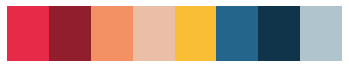

In [9]:
utils.plot.show_default_colors()

In [10]:
def predictions_to_pandas(data):
    labels = pd.read_csv('../data/labels.tsv', sep='\t')
    predictions = np.stack([x[0] for x in data['patient_data'].values()])    
    # Add prediction 1 at time 0 (patients still alive)
    ones = np.ones((predictions.shape[0], 1))
    predictions = np.concatenate((ones, predictions), axis=1)
    
    predictions = pd.DataFrame(predictions, columns=[str(i) for i in range(predictions.shape[-1])])
    patient_ids = list(data['patient_data'].keys())
    predictions['submitter_id'] = patient_ids
    
    predictions = predictions.merge(labels.iloc[:, :-1])
    predictions.set_index('submitter_id', inplace=True)
    
    return predictions

In [11]:
def get_KM_estimates(data, return_kmfitter=False):
    kmf = KaplanMeierFitter()
    kmf.fit(durations=data['time'].values,
            event_observed=data['event'].values)

    if return_kmfitter:
        return kmf

    x = kmf.survival_function_.index.values
    y = kmf.survival_function_
    
    return x, y

In [12]:
# Select and order six models
models_to_use = ['30 one-year intervals', '10 one-year intervals', '5 one-year intervals',
                 '20 half-year intervals', '10 half-year intervals', '20 variable intervals']

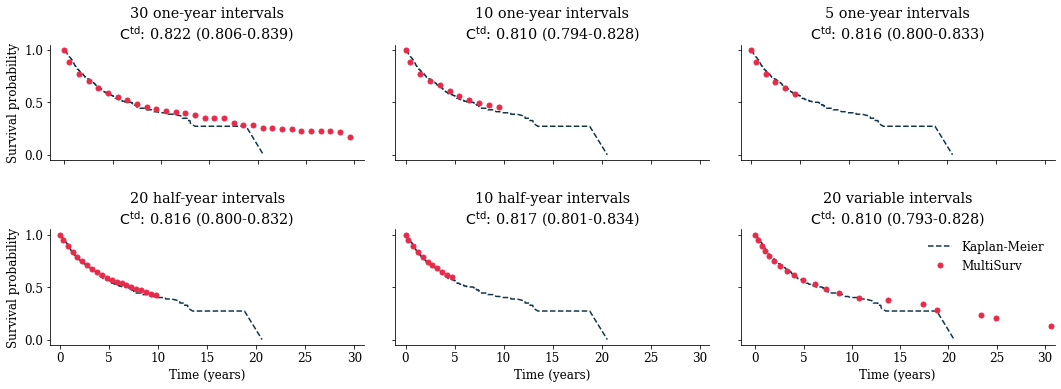

In [13]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axs = plt.subplots(2, 3, figsize=(18, 6))
# fig.suptitle('Pan-cancer patient survival')
axs = axs.ravel()

for i, model in enumerate(models_to_use):
    predictions = predictions_to_pandas(data=results[model])
    
    x, y = get_KM_estimates(predictions)
    axs[i].plot(x, y, '--', color=default_colors[-2], label='Kaplan-Meier')

    time_points = utils.plot.format_output_intervals(models[model].output_intervals)
    len(time_points)
    mean_probabilities = predictions[[str(i) for i in range(len(time_points))]].mean(axis=0).values
    axs[i].plot(time_points, mean_probabilities, 'o', color=default_colors[0],
                markersize=5, label='MultiSurv')
    axs[i].set_title(model + '\n' + r'$\mathrm{C}^{\mathrm{td}}$' + f': {c_td[model]}')
    axs[i].set_xlim(None, 31)
    if i == len(models_to_use) - 1:
        axs[i].legend()

for ax in axs.flat:
    ax.set(xlabel='Time (years)', ylabel='Survival probability')
    ax.label_outer()

plt.subplots_adjust(top=0.82, hspace=0.6, wspace=0.1)

## Save to file

# Watermark<a class='tocSkip'></a>

In [14]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

torch      1.4.0
pandas     1.0.1
matplotlib 3.1.2
numpy      1.18.1

CPython 3.6.7
IPython 7.11.1

last updated: Tue Jul 28 2020


[Top of the page](#Top)